In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data

ca_housing = pd.read_csv('housing.csv')
ca_housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


# Exploratory data analysis

In [3]:
ca_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Data Cleaning 
### Missing Value

As you can see the data seems clean and there is no null, except the total_bedrooms.

In [4]:
(ca_housing.isnull().sum()*100)/ca_housing.isnull().count()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

1% of the data is null so we can drop those. And the missing seems to be missing at random (MAR).

In [5]:
ca_housing['total_bedrooms'] = ca_housing['total_bedrooms'].fillna(ca_housing['total_bedrooms'].mean())
ca_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20640 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Outliers

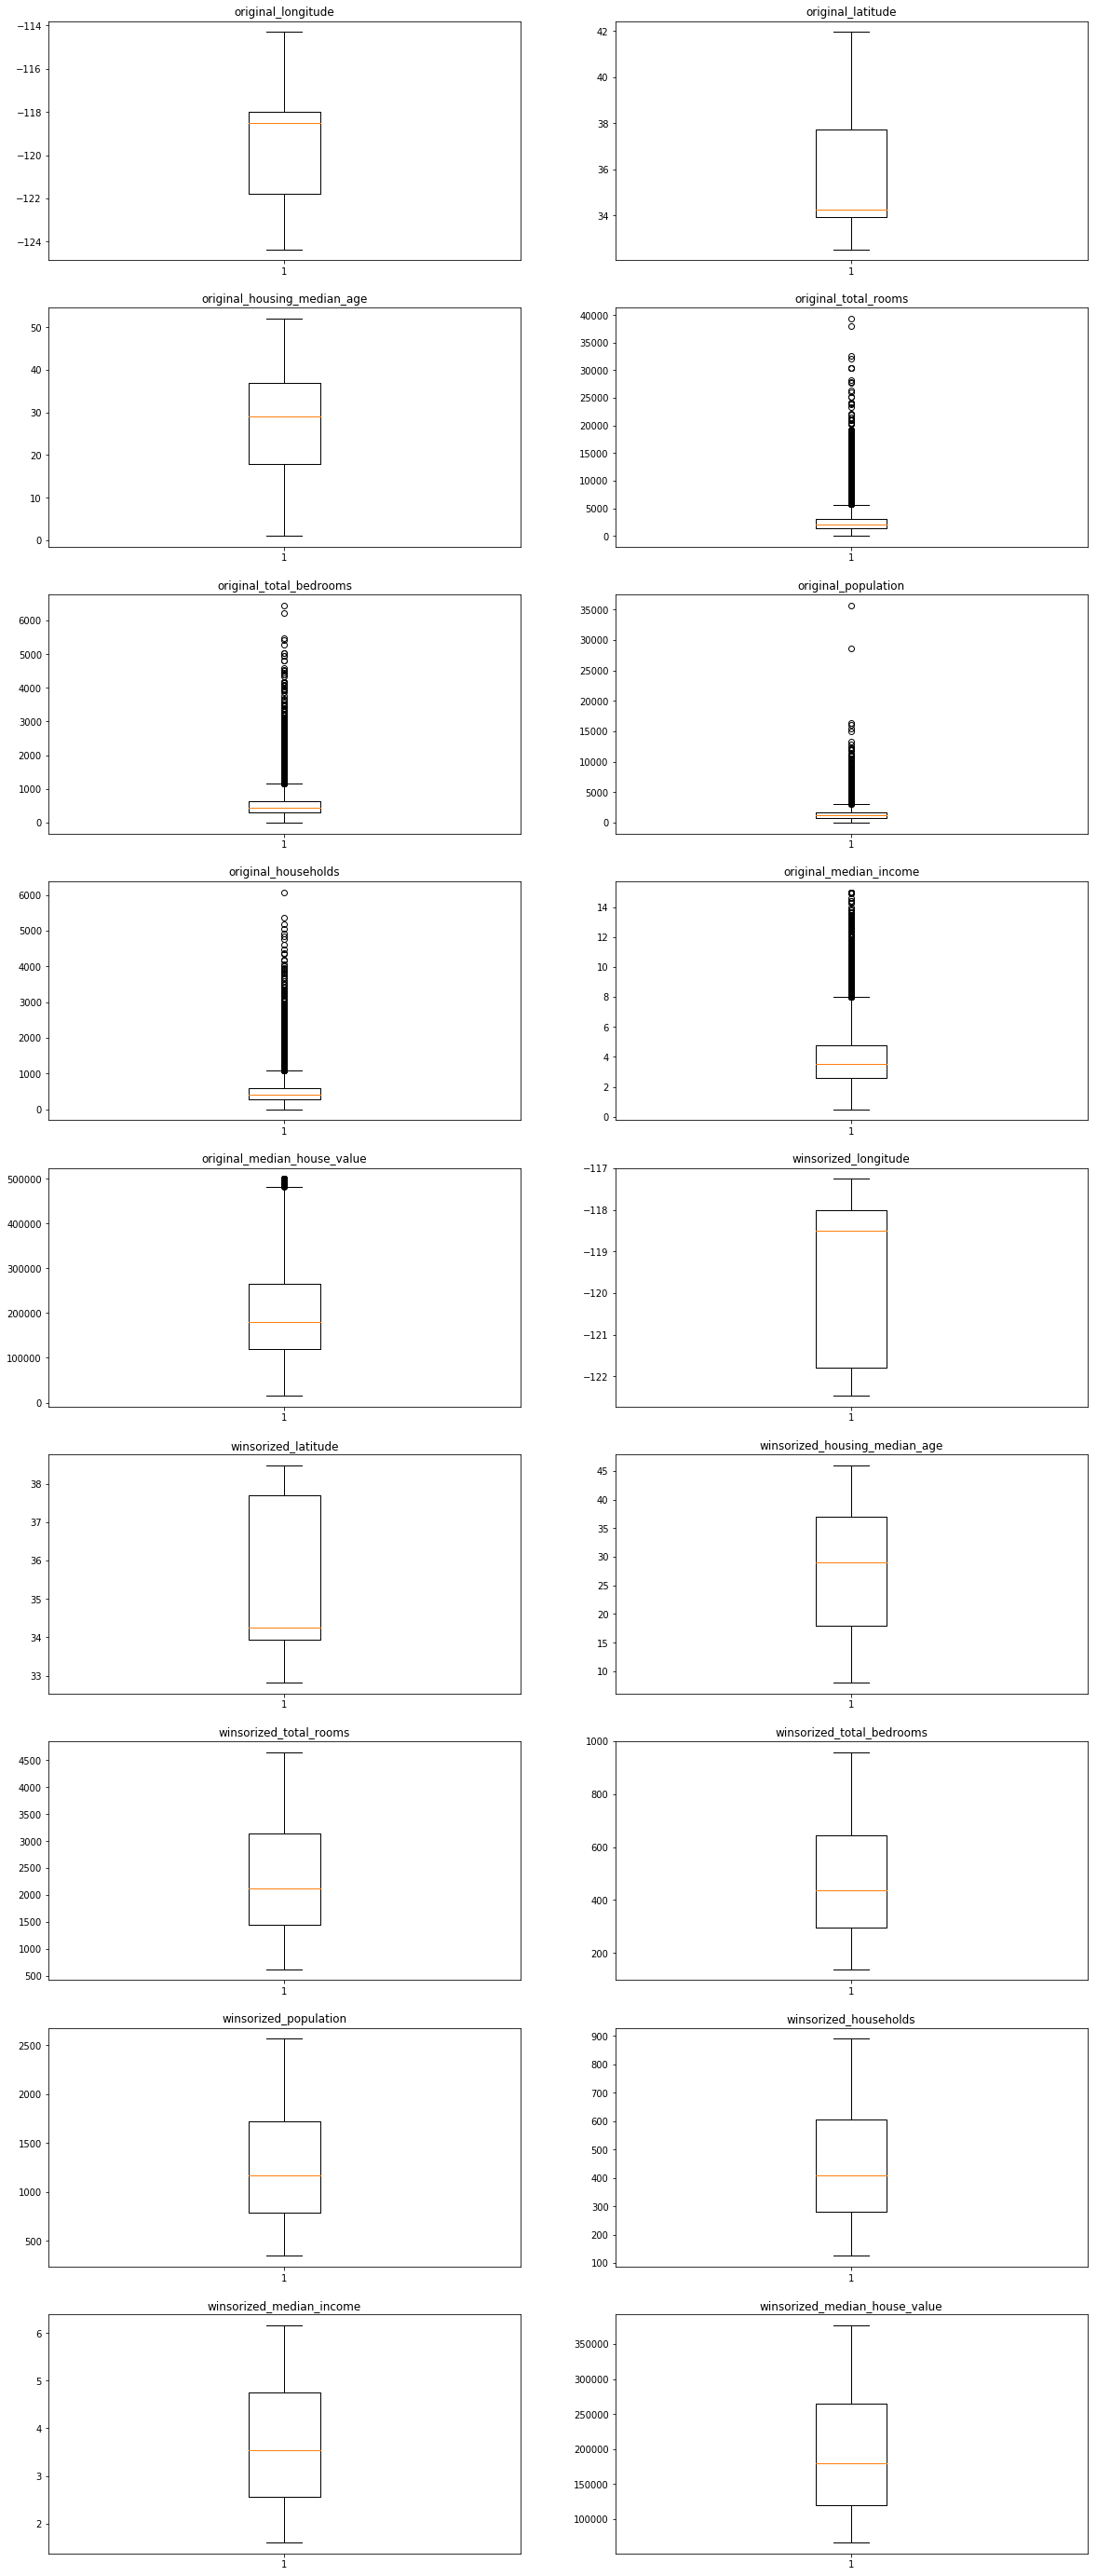

In [6]:
columns = ca_housing.select_dtypes(['int64', 'float64']).columns

# Winsorize outliers
from scipy.stats.mstats import winsorize
plt.figure(figsize=(20,50))

for index, value in enumerate(columns):
    
    plt.subplot(9,2,index+1)
    original = ca_housing[value]
    plt.boxplot(original)
    plt.title("original_" + value)

    plt.subplot(9,2,index+10)
    winsorized = winsorize(ca_housing[value],(.05,0.1))
    plt.boxplot(winsorized)
    plt.title("winsorized_" + value)

plt.show()

In [7]:
# Adding winsorized variables to the data frame.
for column in columns:
    ca_housing['winsorized_' + str(column)] = winsorize(ca_housing[column],(.05,0.1))

In [8]:
ca_housing.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,winsorized_longitude,winsorized_latitude,winsorized_housing_median_age,winsorized_total_rooms,winsorized_total_bedrooms,winsorized_population,winsorized_households,winsorized_median_income,winsorized_median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640,20640.000000,20640.00000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN,-119.582226,35.55622,28.314922,2371.752035,488.962268,1301.009254,456.067926,3.706612,198876.656977
std,2.003532,2.135952,12.585558,2181.615252,419.266592,1132.462122,382.329753,1.899822,115395.615874,NaN,1.914618,1.98502,11.584362,1201.653185,245.511637,662.484281,228.072092,1.403838,96383.780642
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN,-122.470000,32.82000,8.000000,621.000000,138.000000,348.000000,125.000000,1.600600,66200.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,NaN,-121.800000,33.93000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.534800,179700.000000,NaN,-118.490000,34.26000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,NaN,-118.010000,37.71000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000


## Data Exploration
### Univariate analysis

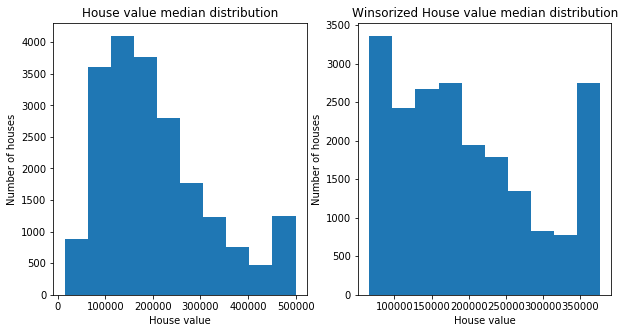

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(ca_housing['median_house_value'])
plt.title('House value median distribution')
plt.xlabel('House value')
plt.ylabel('Number of houses')

plt.subplot(1,2,2)
plt.hist(ca_housing['winsorized_median_house_value'])
plt.title('Winsorized House value median distribution')
plt.xlabel('House value')
plt.ylabel('Number of houses')

plt.show()

The house value distribution in not normal and highly skewed to right. Additionally, there is a jump at the end as well.
All the variables are numeric except the one of them, ocean_proximity.
Let's check the number of unique values of it and then transfer those values to numeric.

In [10]:
print('Unique calues of ocean proximty: {}'.format(ca_housing['ocean_proximity'].unique()))
print('Numer of unique value: {}'.format(ca_housing['ocean_proximity'].nunique()))

Unique calues of ocean proximty: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
Numer of unique value: 5


In [11]:
ca_housing.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,winsorized_longitude,winsorized_latitude,winsorized_housing_median_age,winsorized_total_rooms,winsorized_total_bedrooms,winsorized_population,winsorized_households,winsorized_median_income,winsorized_median_house_value
longitude,1,-0.924664,-0.108197,0.044568,0.0692597,0.0997732,0.0553101,-0.0151759,-0.0459666,0.993134,-0.936662,-0.0910539,0.0245246,0.0589646,0.117473,0.0531366,-0.0162233,-0.0476977
latitude,-0.924664,1,0.0111727,-0.0360996,-0.0666584,-0.108785,-0.0710354,-0.0798091,-0.14416,-0.924569,0.987538,-0.00567266,-0.0247844,-0.064827,-0.135848,-0.0796459,-0.0868442,-0.155095
housing_median_age,-0.108197,0.0111727,1,-0.361262,-0.318998,-0.296244,-0.302916,-0.119034,0.105623,-0.102906,0.024774,0.993627,-0.37264,-0.320418,-0.302476,-0.299351,-0.151969,0.0935414
total_rooms,0.044568,-0.0360996,-0.361262,1,0.927253,0.857126,0.918484,0.19805,0.134153,0.0423466,-0.0323316,-0.363075,0.801329,0.746873,0.690988,0.741775,0.227351,0.145126
total_bedrooms,0.0692597,-0.0666584,-0.318998,0.927253,1,0.87391,0.974725,-0.00768188,0.0494535,0.0671164,-0.0641426,-0.321519,0.769606,0.832467,0.738327,0.809897,0.015431,0.0624591
population,0.0997732,-0.108785,-0.296244,0.857126,0.87391,1,0.907222,0.00483435,-0.0246497,0.100988,-0.103811,-0.294274,0.687309,0.724136,0.8172,0.747854,0.0265478,-0.00944236
households,0.0553101,-0.0710354,-0.302916,0.918484,0.974725,0.907222,1,0.0130331,0.0658427,0.0556769,-0.066169,-0.305183,0.773407,0.819041,0.772286,0.837418,0.0401946,0.0814717
median_income,-0.0151759,-0.0798091,-0.119034,0.19805,-0.00768188,0.00483435,0.0130331,1,0.688075,-0.0140718,-0.0599583,-0.121825,0.230474,-0.0335241,-0.019619,-0.00516167,0.917164,0.664194
median_house_value,-0.0459666,-0.14416,0.105623,0.134153,0.0494535,-0.0246497,0.0658427,0.688075,1,-0.0425773,-0.117498,0.0961121,0.179929,0.0601864,-0.0359151,0.079655,0.657692,0.977497
winsorized_longitude,0.993134,-0.924569,-0.102906,0.0423466,0.0671164,0.100988,0.0556769,-0.0140718,-0.0425773,1,-0.943194,-0.0849249,0.0231737,0.0583739,0.119128,0.0541208,-0.0151512,-0.0441932


1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

<Figure size 2160x3600 with 0 Axes>

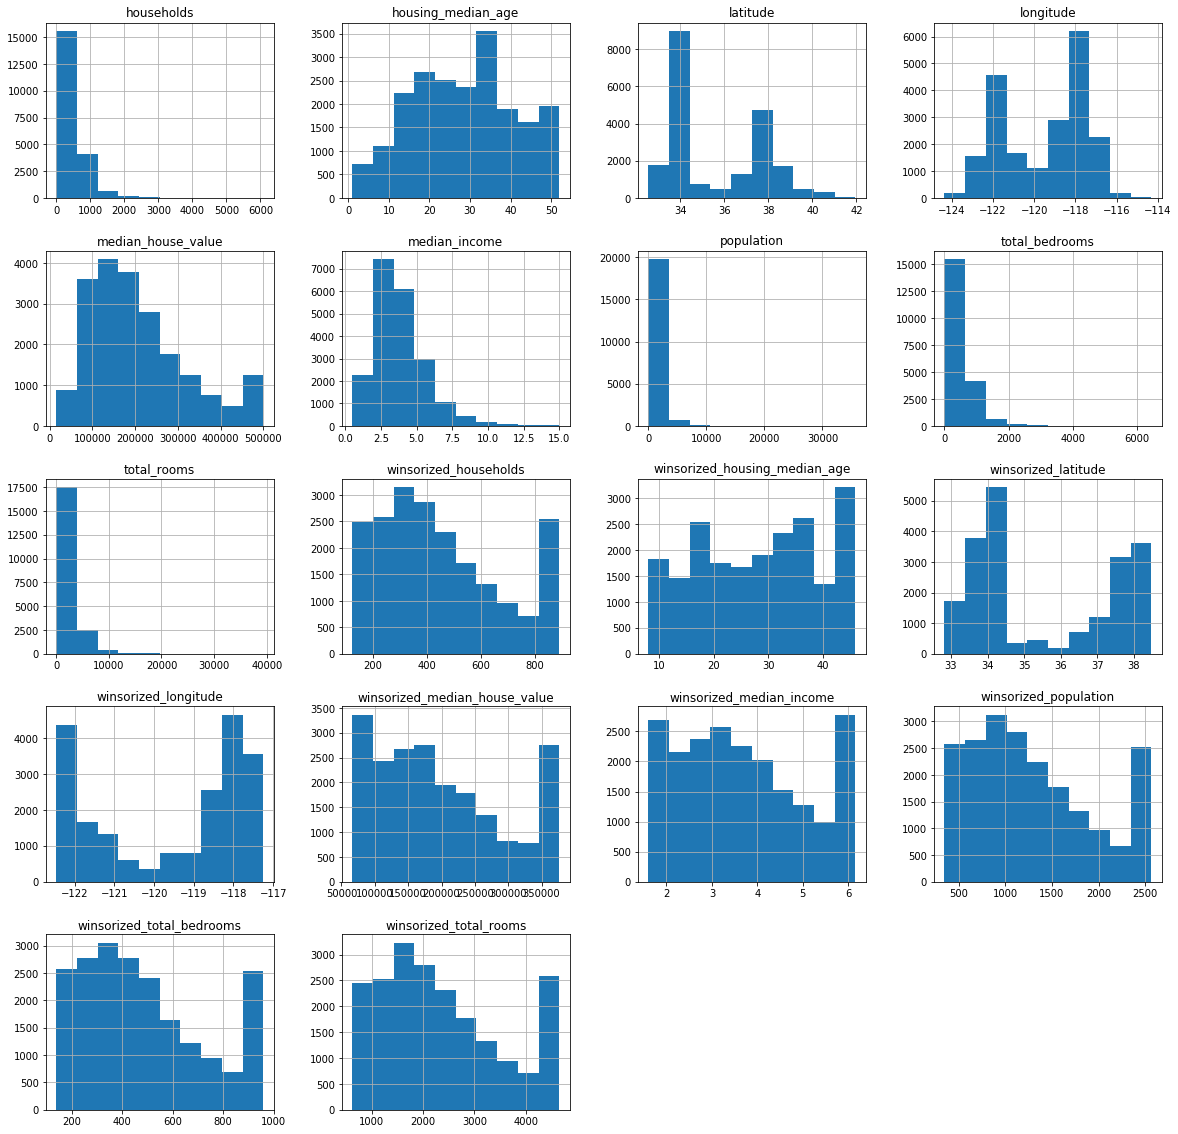

In [12]:
plt.figure(figsize=(30,50))

ca_housing.hist(bins=10, figsize=(20,20))

#    for index, column in enumerate(X.columns):
#        plt.subplot(3,4,index+1)
#        plt.bar(ca_housing.groupby(column)['median_house_value'].mean().index,
#              ca_housing.groupby(column)['median_house_value'].mean())
#        plt.title(column)
plt.show()

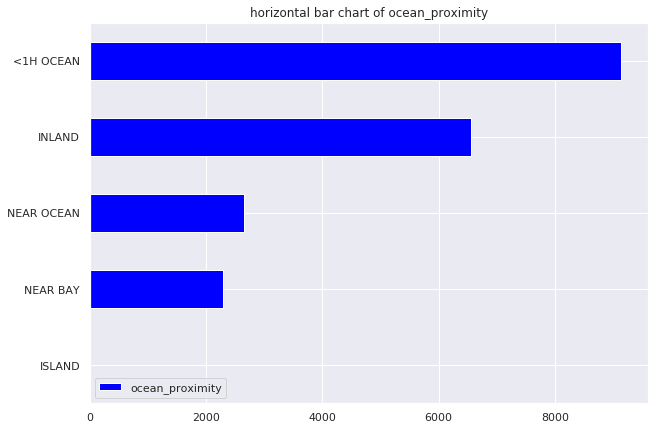

In [13]:
sns.set(palette='Set2')
ca_housing.ocean_proximity.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(10,7),color='b')
plt.legend()
plt.title("horizontal bar chart of ocean_proximity")

plt.show()

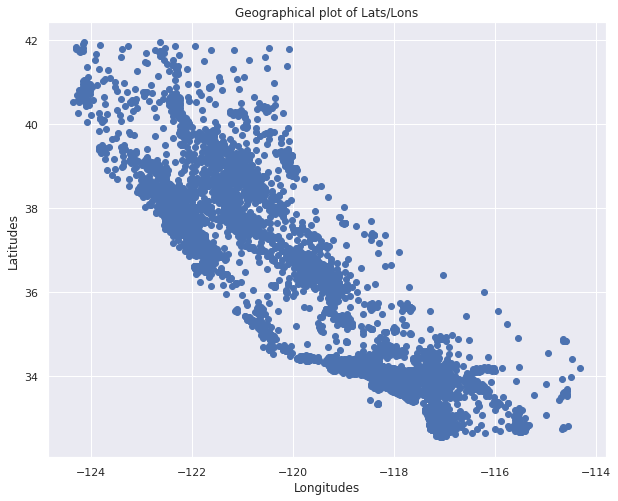

In [14]:
sns.set()
plt.figure(figsize=(10,8))#Figure size
plt.scatter('longitude','latitude',data=ca_housing)
plt.ylabel('Latitudes')
plt.xlabel('Longitudes')
plt.title('Geographical plot of Lats/Lons')
plt.show()

#### The plot looks like Calofornia.
But we don't have a informative look on the plot since we need to know the density for each point, let's do a simple modification.


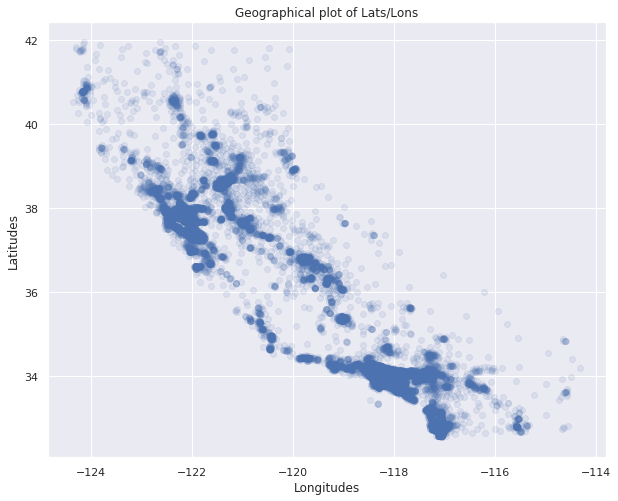

In [15]:
sns.set()
plt.figure(figsize=(10,8))#Figure size
plt.scatter('longitude','latitude',data=ca_housing,alpha=0.1)
plt.ylabel('Latitudes')
plt.xlabel('Longitudes')
plt.title('Geographical plot of Lats/Lons')
plt.show()

Now it's much better , and if we're familiar with Californias map we can see clearly that the high-density areas , namely the Bay Area and all around Los Angeles & San diego More generally our brains can spot patterns visually , but we always need to play around with the vizualisations to make the patterns stands out.

<Figure size 720x504 with 0 Axes>

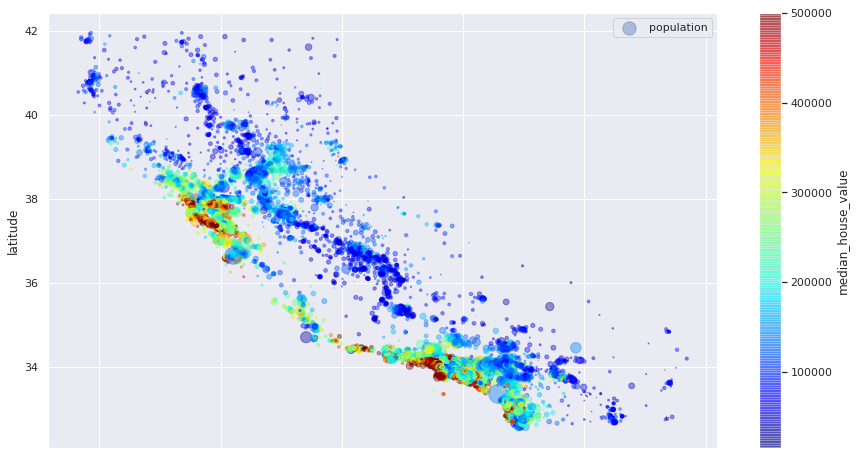

In [16]:
plt.figure(figsize=(10,7))
ca_housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=ca_housing["population"]/100, label="population", figsize=(15,8),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()

Now we can say that the house price is a bit related to the location (e.g close to ocean) and to the density of the population.

### Bivariate analysis

In [17]:
corr_matrix=ca_housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value               1.000000
winsorized_median_house_value    0.977497
median_income                    0.688075
winsorized_median_income         0.657692
winsorized_total_rooms           0.179929
total_rooms                      0.134153
housing_median_age               0.105623
winsorized_housing_median_age    0.096112
winsorized_households            0.079655
households                       0.065843
winsorized_total_bedrooms        0.060186
total_bedrooms                   0.049454
population                      -0.024650
winsorized_population           -0.035915
winsorized_longitude            -0.042577
longitude                       -0.045967
winsorized_latitude             -0.117498
latitude                        -0.144160
Name: median_house_value, dtype: float64

Comparing the correlation of features with target above to see which features have the hight effect.

<Figure size 1440x1440 with 0 Axes>

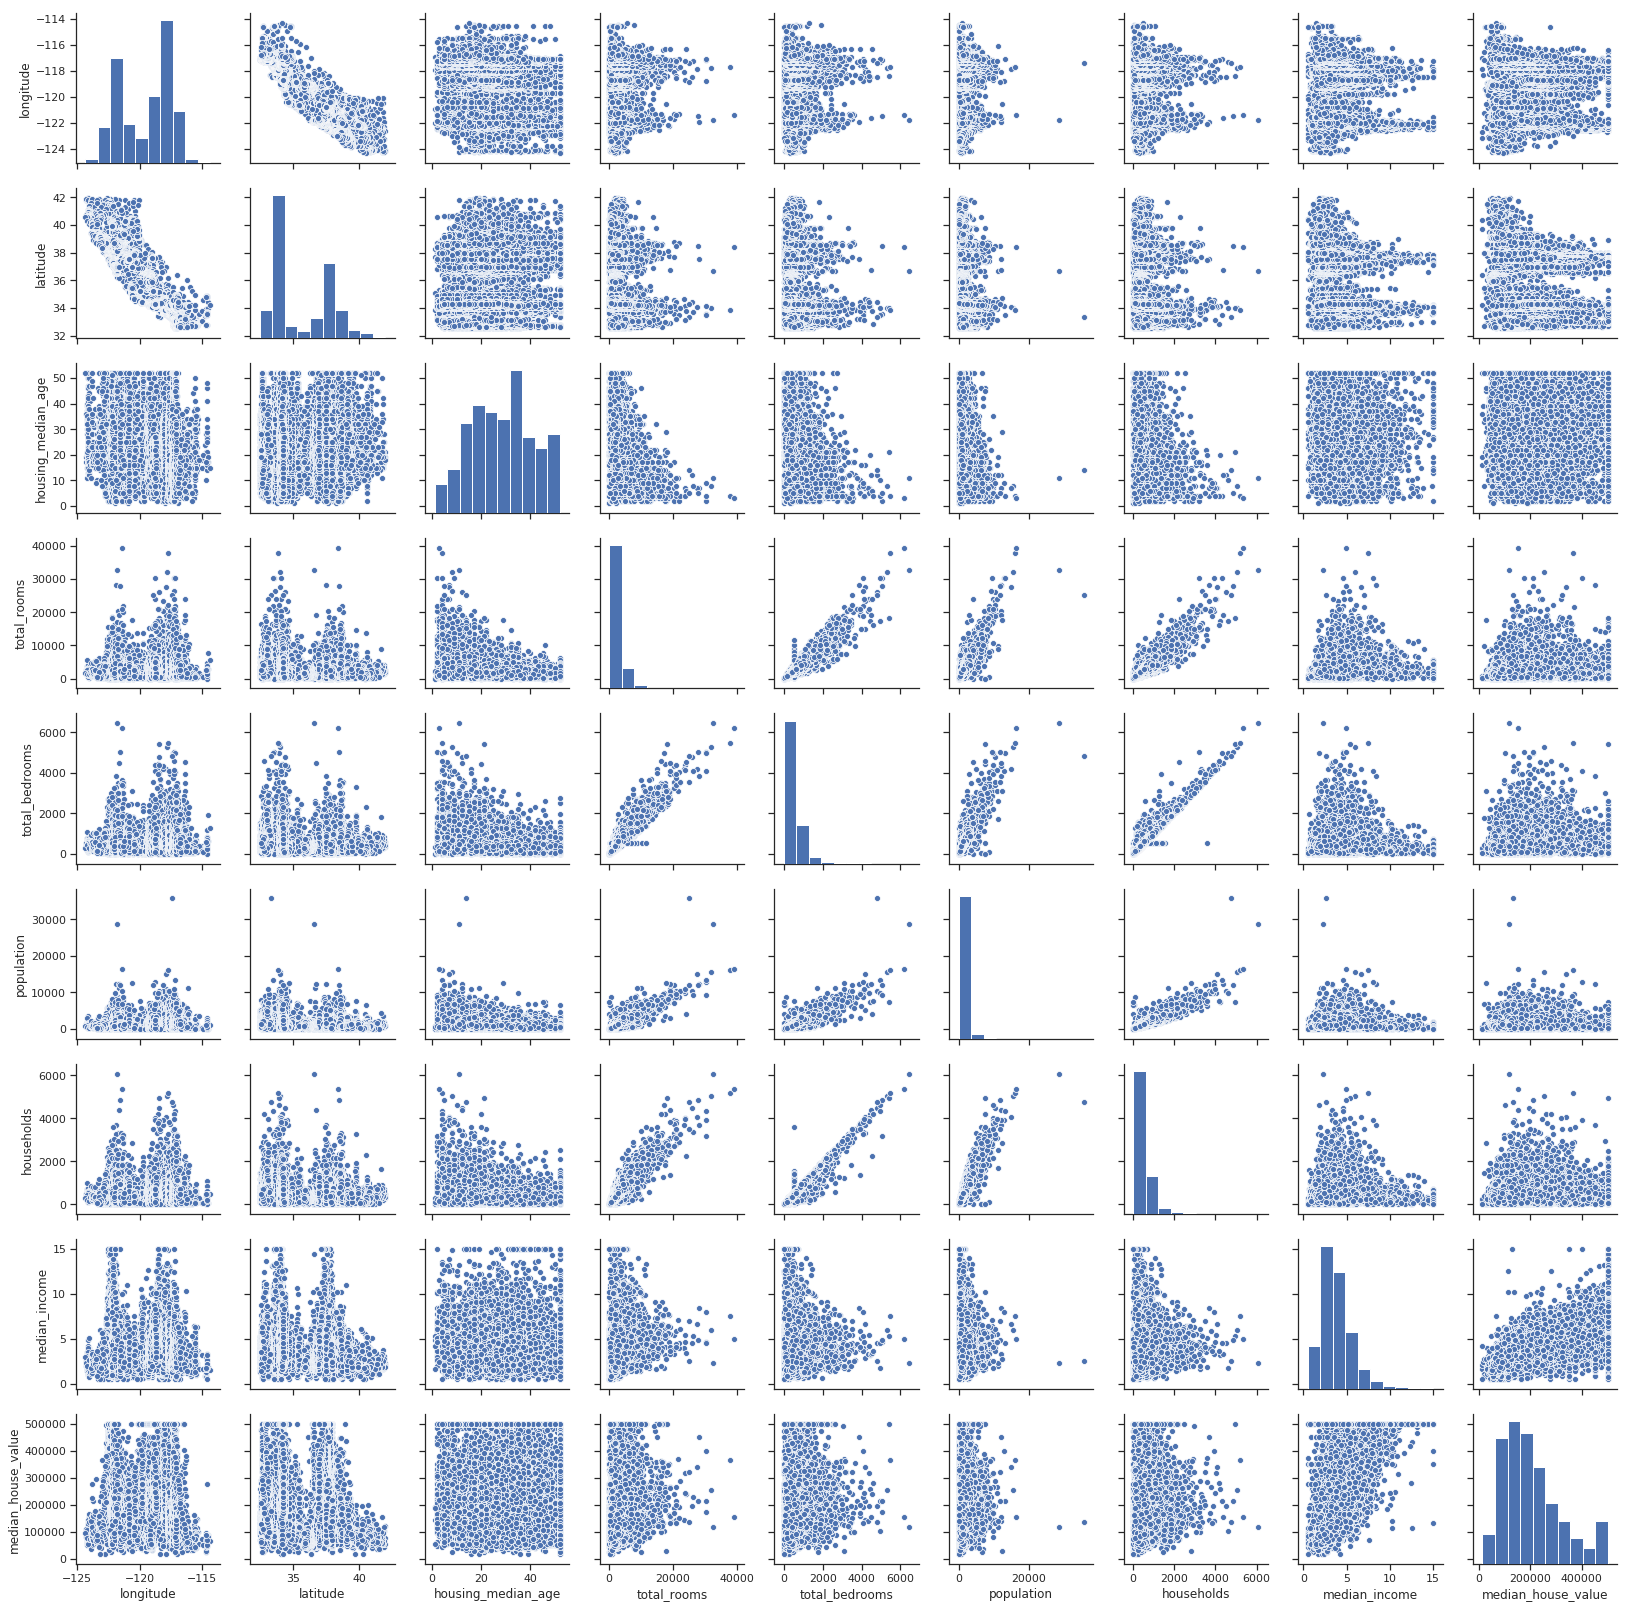

In [18]:
# Compare each pair of feature together
plt.figure(figsize=(20,20))
sns.set(style="ticks")
sns.pairplot(ca_housing[columns])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80a3d72e10>,
      dtype=object)

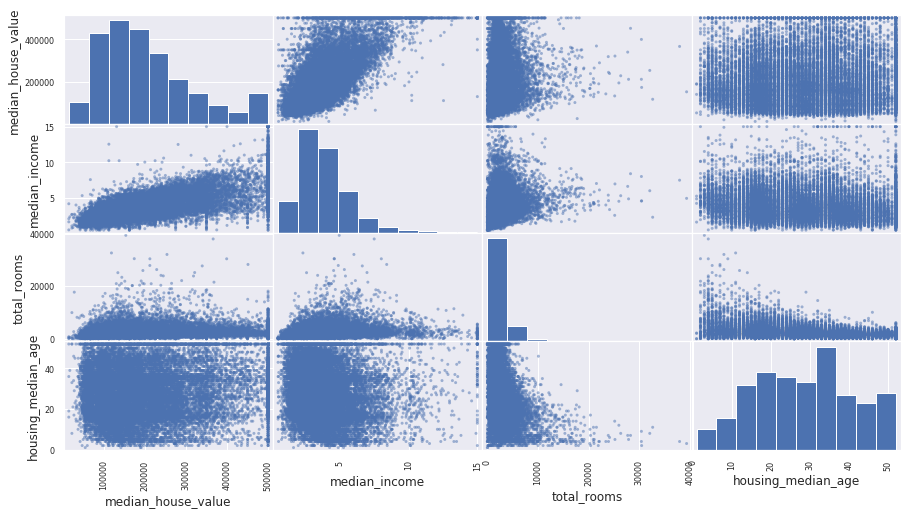

In [19]:
# Compare highly correlated pair of feature together
sns.set()
feat = ['median_house_value','median_income','total_rooms','housing_median_age']
pd.plotting.scatter_matrix(ca_housing[feat],figsize=(15,8))

Looking at the relation of target variable and most related featuers with target.

In [20]:
# adding feature
ca_housing['rooms_per_household']= ca_housing['total_rooms'] / ca_housing.households

In [21]:
corr_matrix1=ca_housing.corr()
corr_matrix1.median_house_value.sort_values(ascending=False)

median_house_value               1.000000
winsorized_median_house_value    0.977497
median_income                    0.688075
winsorized_median_income         0.657692
winsorized_total_rooms           0.179929
rooms_per_household              0.151948
total_rooms                      0.134153
housing_median_age               0.105623
winsorized_housing_median_age    0.096112
winsorized_households            0.079655
households                       0.065843
winsorized_total_bedrooms        0.060186
total_bedrooms                   0.049454
population                      -0.024650
winsorized_population           -0.035915
winsorized_longitude            -0.042577
longitude                       -0.045967
winsorized_latitude             -0.117498
latitude                        -0.144160
Name: median_house_value, dtype: float64

The number of rooms per household is now more informative than the total number of rooms in a district

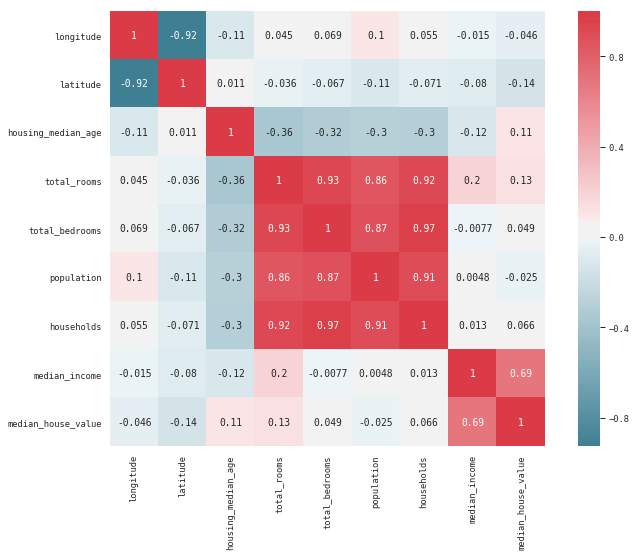

In [22]:
#heatmap using seaborn
#set the context for plotting 
ca_housing = pd.concat([ca_housing,pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True)], axis=1)
dummy_columns = list(pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True).columns)

sns.set(context="paper",font="monospace")
housing_corr_matrix = ca_housing[columns].corr()
#set the matplotlib figure
fig, axe = plt.subplots(figsize=(12,8))
#Generate color palettes 
cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
#draw the heatmap
sns.heatmap(housing_corr_matrix,vmax=1,square =True, cmap=cmap,annot=True )

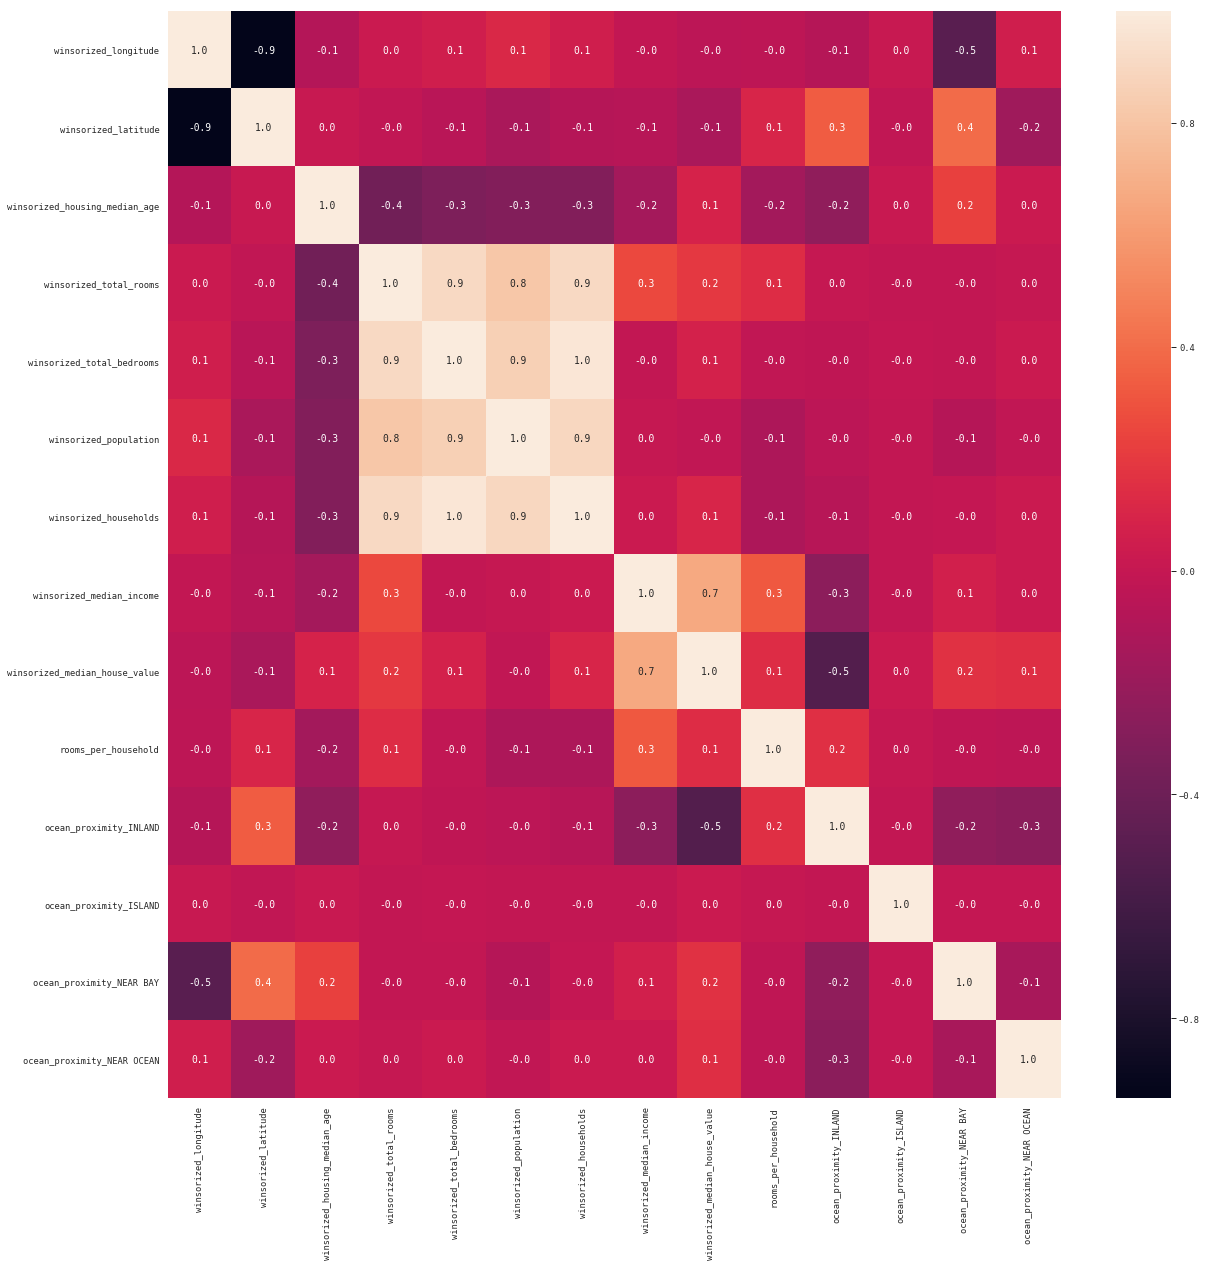

In [23]:
Winsorized_ca_housing = ca_housing.iloc[:,9:]
plt.figure(figsize=(20,20))
sns.heatmap(Winsorized_ca_housing.corr(),annot=True,fmt='.1f')
plt.show()

### Correlation Analysis

We want to further explore the data to look for correlations between different attributes. correlation coefficient is between -1 and 1, representing negative and positive correlations. 0 means there is no liner correlation. Correlation is said to be linear if the ratio of change is constant, otherwise is non-linear. Visual inspection of data is very important, which cannot be replaced by simply looking at the correlation coefficients

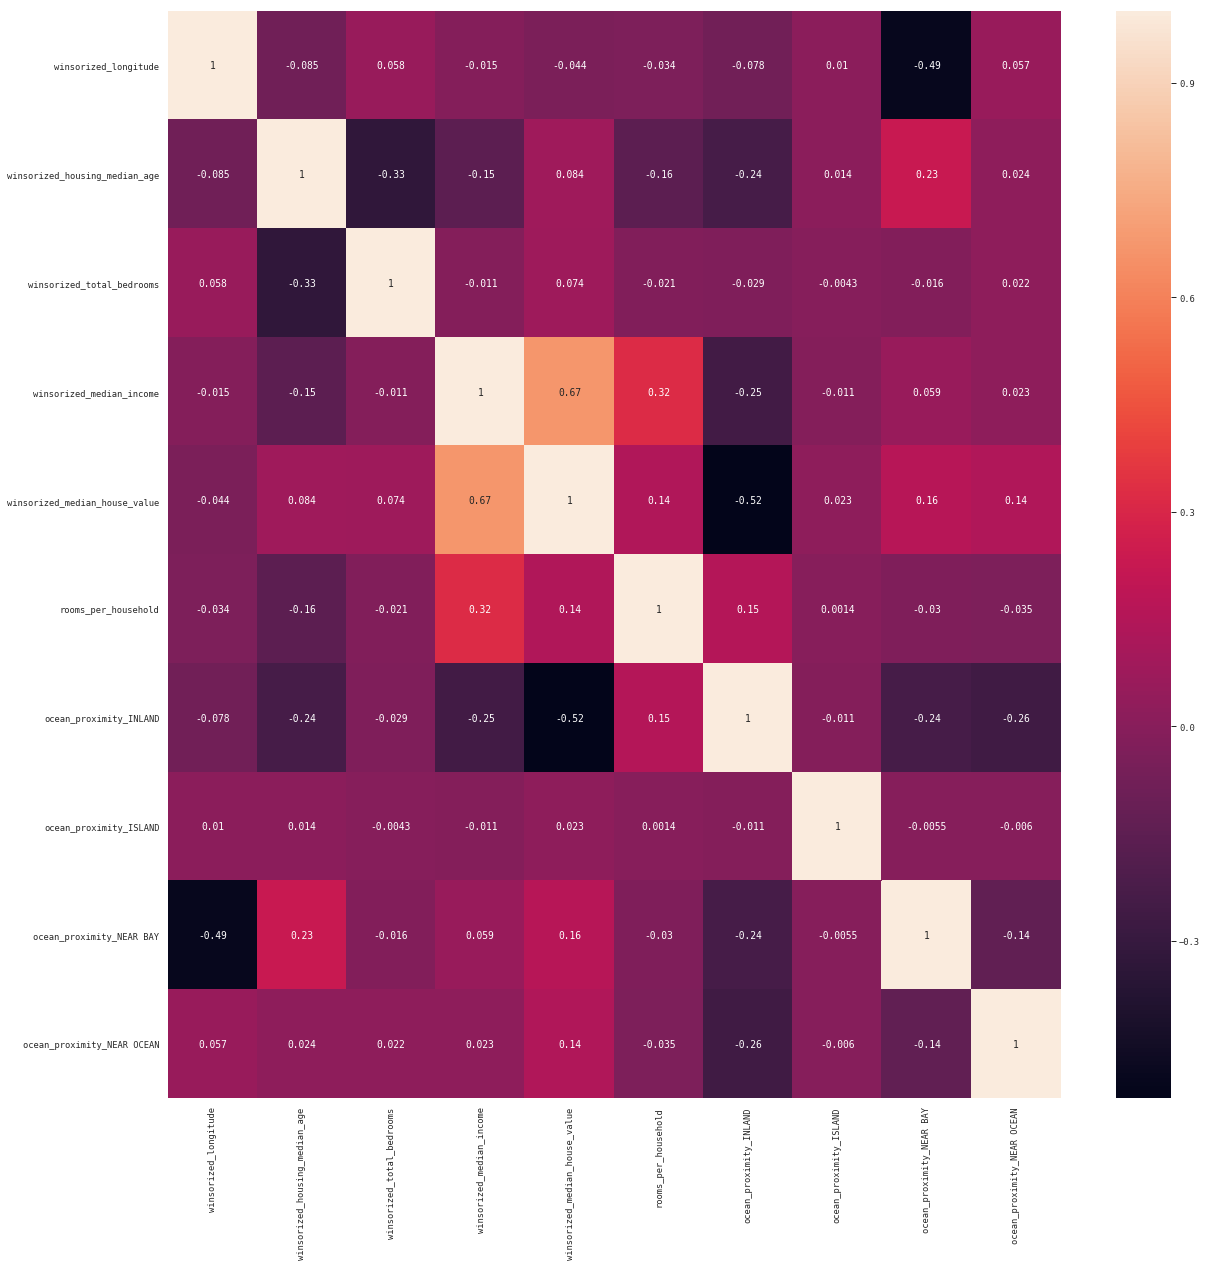

In [24]:
# Find features with correlation greater than 0.75
to_drop = ['winsorized_total_rooms', 'winsorized_households', 
           'winsorized_population', 'winsorized_latitude']


Winsorized_ca_housing = Winsorized_ca_housing.drop(to_drop, axis=1)
plt.figure(figsize=(20,20))
sns.heatmap(Winsorized_ca_housing.corr(),annot=True)
plt.show()

Highly corelated features are dropes and the heatmap shows only less related features. Until now we just study the data to see how they are corelated to each other and the target data. Now it's time to work on our regression modeling.

# Modeling

Now we transfer our object feature to numeric variable. Then drop object type variable and the target to create our modeling.

In [25]:
ca_housing = pd.concat([ca_housing,pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True)], axis=1)
dummy_columns = list(pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True).columns)
ca_husing = ca_housing.dropna()
X = ca_housing.drop(['median_house_value','ocean_proximity'], axis=1) 
Y = ca_housing['median_house_value']

In [26]:
# creating linear regression model
lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

print('The linear model coefficients:', lrm.coef_)
print('The Linear model intercept:',lrm.intercept_)

The linear model coefficients: [-1.30834990e+03  3.09732707e+03  2.40072893e+02 -6.47942145e-01
  3.22596738e+00 -3.09258837e-01  6.46495365e-01  1.52025735e+04
  1.86185733e+03 -3.46074280e+03 -6.57423529e+01 -2.11719945e-01
  9.80091339e+00 -4.34279553e+00  2.22031132e+00 -1.67566698e+04
  1.15165515e+00 -4.06507318e+01  4.18650608e+03  2.70407992e+03
  1.98969799e+03  1.32302268e+03  4.18650608e+03  2.70407992e+03
  1.98969799e+03  1.32302268e+03]
The Linear model intercept: 52181.5706863706


In [27]:
from sklearn.model_selection import cross_val_score

cross_val_score(lrm, X, Y, cv=5)

array([0.9761212 , 0.95785209, 0.95395613, 0.96516459, 0.96652603])

In [28]:

cross_val_score(lrm, X, Y, cv=5).mean()

0.9639240084646963

As we can see above the linear model is not overfitting, therefore we do not need tune the modeling again. The model based on train set has %96 accuracy.

In [29]:
ca_housing = pd.concat([ca_housing,pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True)], axis=1)
dummy_columns = list(pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True).columns)
Winsorized_ca = Winsorized_ca_housing.dropna()
XX = Winsorized_ca_housing.drop(['winsorized_median_house_value','ocean_proximity'], axis=1) 
Y = ca_housing['winsorized_median_house_value']

In [30]:
# Standardizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(XX)

In [31]:
# creating linear regression model
lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

print('The linear model coefficients:', lrm.coef_)
print('The Linear model intercept:',lrm.intercept_)

The linear model coefficients: [ -5769.25846612  13021.40802058  11408.69794609  58229.0162088
   1988.45107794 -31672.83557396   2478.92114631   -369.55879668
   4071.47927473]
The Linear model intercept: 198876.65697674415


In [32]:
linear_pred = lrm.predict(X)
linear_errors = Y - linear_pred
print('The mean of linear regression errors is: {}'.format(np.mean(linear_errors)))

The mean of linear regression errors is: 1.9853775815446247e-12


In [33]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(linear_pred, linear_errors)
lev_stats = levene(linear_pred, linear_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 1012.92 and p value is 2.8e-222
Levene test statistic value is 1662.45 and p value is 0


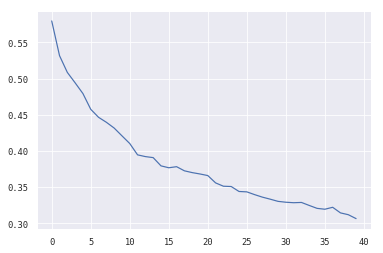

In [34]:
from statsmodels.tsa.stattools import acf

acf_data = acf(linear_errors)

plt.plot(acf_data[1:])
plt.show()

#### All the six requierments for the linear regression are meet.

In [35]:
# Now we will try creating linear regression model along with LASSO and Ridge

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 16512
The number of observations in test set is 4128
R-squared of the model in the training set is: 0.6099116549458514
-----Test set statistics-----
R-squared of the model in the test set is: 0.6071860725256828
Mean absolute error of the prediction is: 46752.871903360494
Mean squared error of the prediction is: 3698246271.249977
Root mean squared error of the prediction is: 60813.20803287701
Mean absolute percentage error of the prediction is: 26.69710746659293


In [36]:
print('The linear model coefficients:', lrm.coef_)
print('The Linear model intercept:',lrm.intercept_)

The linear model coefficients: [ -5972.70471     13403.13397412  11076.51718437  58369.16613308
   2121.13004425 -31578.03133702   2480.69893762   -234.5076389
   3936.03586613]
The Linear model intercept: 198598.82172179504


In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(lrm, X_train, y_train, cv=5)

array([0.6136675 , 0.6013765 , 0.61922577, 0.61422277, 0.59732692])

In [38]:
cross_val_score(lrm, X_test, y_test, cv=5)

array([0.60312537, 0.58951111, 0.61199534, 0.5976945 , 0.62605445])

In [39]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**2) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



R-squared of the model on the training set is: 0.6098925195553488
-----Test set statistics-----
R-squared of the model on the test set is: 0.6072168915844705
Mean absolute error of the prediction is: 46766.95749583197
Mean squared error of the prediction is: 3697956117.41053
Root mean squared error of the prediction is: 60810.82237077977
Mean absolute percentage error of the prediction is: 26.703641554773156


In [40]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**2) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



R-squared of the model on the training set is: 0.609899236295393
-----Test set statistics-----
R-squared of the model on the test set is: 0.6071962775306283
Mean absolute error of the prediction is: 46757.6552707079
Mean squared error of the prediction is: 3698150193.644658
Root mean squared error of the prediction is: 60812.41808746514
Mean absolute percentage error of the prediction is: 26.689001635572808


### KNN

In [41]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

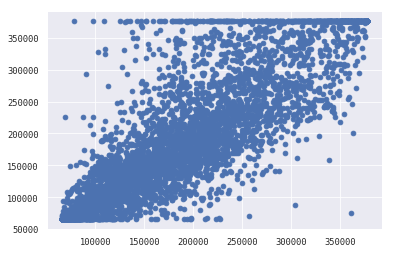

In [42]:
knn_pred = knn.predict(X_test)
knn_errors = y_test - knn_pred
plt.scatter(knn_pred,y_test)

In [43]:
# Cross Validation

cross_val_score(knn, X_train, y_train, cv=5)

array([0.67332393, 0.67186753, 0.68817416, 0.68023067, 0.66488587])

In [44]:
# Cross Validation

cross_val_score(knn, X_test, y_test, cv=5)

array([0.64075948, 0.60790901, 0.63758691, 0.63041618, 0.65974517])

### Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor


random_forest = RandomForestRegressor()
random_forest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:
# Cross Validation

cross_val_score(random_forest, X_train, y_train, cv=5)

array([0.7096165 , 0.70165814, 0.72673184, 0.71547791, 0.70535808])

In [47]:
# Cross Validation

cross_val_score(random_forest, X_test, y_test, cv=5)

array([0.65420026, 0.64051287, 0.65567298, 0.66106449, 0.65948311])

In [48]:
pred_random_forest_test = random_forest.predict(X_test)
random_forest.score(X_test,y_test)

0.7146375553180653

In [49]:
params = {'n_estimators': 8,
         'max_depth': 8}

random_forest1 = RandomForestRegressor(**params)
random_forest1.fit(X_train,y_train)
random_forest1.score(X_train,y_train)

0.7508005113847688

Here we have underfitting.

In [50]:
pred_random_forest_test = random_forest1.predict(X_test)
random_forest1.score(X_test,y_test)

0.692385517223362

Now the difference between the training data and test data is close. But now we have overfitting.

### Support Vector

In [51]:
from sklearn.svm import SVR
svr = SVR()

svr.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
svr.score(X_train,y_train)

-0.028665179353865033

In [53]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-3.42796177e-02, -1.38325198e-01, -2.74964299e-01, -2.01573925e-06,
       -1.69541442e-01])

In [54]:
cross_val_score(svr, X_test, y_test, cv=5)

array([-0.04891723, -0.02612119, -0.02791117, -0.02092108, -0.02660061])

### Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=5)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [56]:
decision_tree.score(X_train, y_train)

0.6426278940468191

In [57]:
pred_tree = decision_tree.predict(X_test)

from sklearn.metrics import explained_variance_score

explained_variance_score(y_test,pred_tree,multioutput='uniform_average')


0.6197769795185508

### Tune the Model

There are different ways you can fine tune your model:

- try different combinations of hyperparameters of a model: a. the following example trys 18 different combinations of hyperparameters and find the best one b. you can also use Randomized Search to try more combinations when the search space is very large
- combine the best performing models

In [58]:
random_forest = RandomForestRegressor()
random_forest.fit(X, Y)
random_forest.score(X, Y)

0.949882223992116

In [59]:
# use GridSearch to find best hyperparameter combinations
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features': [3,4,5,6,7,8]},  # try 3x4=12 combinations
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},  # try 2x3=6 combinations
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')  # each model is trained 5 times, so (12+6)*5 = 80 rounds of training in total
grid_search.fit(X, Y)
grid_search.best_params_  # best parameters

{'max_features': 3, 'n_estimators': 30}

In [60]:
grid_search.best_estimator_  # best estimators

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [61]:
# The importance of the features
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.57241571e-01, 6.61534441e-02, 6.51551745e-02, 3.82342402e-01,
       1.37317023e-01, 1.69509370e-01, 3.06958625e-04, 9.57724596e-03,
       1.23968109e-02])

In [62]:
random_forest = RandomForestRegressor(max_features= 3)
random_forest.fit(X, Y)
random_forest.score(X, Y)

0.950674535998528

So now we try to tune our decision tree model based on following information.

In [63]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition

sc = StandardScaler()

# Create a pca object
pca = decomposition.PCA()

    # Create a logistic regression object with an L2 penalty
decisiontree = DecisionTreeRegressor()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('decisiontree', decisiontree)])

    # Create Parameter Space
    # Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(decisiontree__max_depth=max_depth)

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
clf.fit(X, Y)

    # View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

    # Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X, Y, cv=5, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: mse
Best max_depth: 6
Best Number Of Components: None

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

[0.47253131 0.22801083 0.52394192 0.24703857 0.59141969]

0.4125884644802357

0.1479520285446631


In [64]:
decision_tree = DecisionTreeRegressor(max_depth=6)
decision_tree.fit(X, Y)
decision_tree.score(X, Y)

0.6662627955795855

In [65]:
pred_tree = decision_tree.predict(X)

from sklearn.metrics import explained_variance_score

explained_variance_score(Y,pred_tree,multioutput='uniform_average')


0.6662627955795855

Based on the feature importance, you can choose to drop some features such as the last four ocean proximity features to simplify the model. In the following example, the performanc on the test set is actually better than the validation set.

Finally, comparing different regression models and their cross validation scores show that Random Forest has the highest and aslo more consistent modeling. comparing the cross validation score for training and test sets are close, which means we do not have any overfitting.

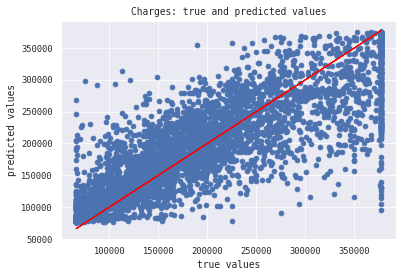

In [66]:
# Making predictions

random_forest1.fit(X_train,y_train)

# We are making predictions here
y_preds = random_forest1.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

In [67]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 38812.36890879643
Mean squared error of the prediction is: 2884153567.703301
Root mean squared error of the prediction is: 53704.31609939094
Mean absolute percentage error of the prediction is: 22.136759943551333


The function automatically includes another variable that the chosen variable interacts most with. The above plot shows there is an approximately linear and positive trend between median_income and the target variable, and median_income interacts with housing_median_age frequently.

In this project, I check different features that effect the CA housong prices and find the one with hight correlation on media value house. By looking at these features we are able to predict the feature price of houses by some degree of error.

By comparing above models and their scores and cross validation, we can see that Linear Regression has the best performance with %96. Even after tuning the decision tree and random forest we can still see that linear regression has better performance.